In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
from google.colab import files
uploaded = files.upload()

Saving deu.txt to deu (4).txt


In [5]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [6]:
deu_eng = deu_eng[:50000,:]

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [8]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [9]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn', 'Wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together', 'Wir waren zusammen auf Reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together', 'Wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [10]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [11]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['we took a wrong turn', 'wir sind falsch abgebogen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['we traveled together', 'wir waren zusammen auf reisen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['we traveled together', 'wir sind zusammen gereist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [12]:
eng_l = []
deu_l = []
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

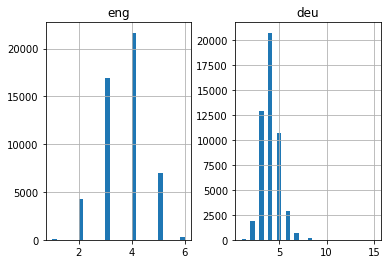

In [14]:
length_df.hist(bins = 30)
plt.show()

In [15]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6152


In [28]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10112


In [18]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [20]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [21]:
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [22]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [23]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
filename = 'model.h1.24_amdzs'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=5, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/5
63/63 [==============================] - 210s 3s/step - loss: 4.3072 - val_loss: 2.8128

Epoch 00001: val_loss improved from inf to 2.81280, saving model to model.h1.24_amdzs


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


Epoch 2/5
63/63 [==============================] - 191s 3s/step - loss: 2.7314 - val_loss: 2.6678

Epoch 00002: val_loss improved from 2.81280 to 2.66781, saving model to model.h1.24_amdzs


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


Epoch 3/5
63/63 [==============================] - 187s 3s/step - loss: 2.5857 - val_loss: 2.5355

Epoch 00003: val_loss improved from 2.66781 to 2.53545, saving model to model.h1.24_amdzs


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


Epoch 4/5
63/63 [==============================] - 189s 3s/step - loss: 2.3905 - val_loss: 2.3765

Epoch 00004: val_loss improved from 2.53545 to 2.37646, saving model to model.h1.24_amdzs


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


Epoch 5/5
63/63 [==============================] - 189s 3s/step - loss: 2.2253 - val_loss: 2.2599

Epoch 00005: val_loss improved from 2.37646 to 2.25994, saving model to model.h1.24_amdzs


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


INFO:tensorflow:Assets written to: model.h1.24_amdzs/assets


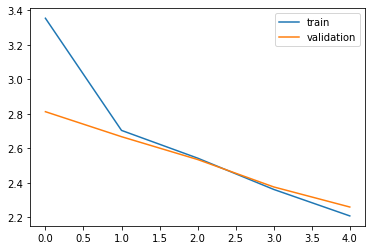

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [26]:
model = load_model('model.h1.24_amdzs')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [37]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [38]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [32]:
pd.set_option('display.max_colwidth', 200)

In [39]:
pred_df.head(15)

,actual,predicted
0,what is the number,please the
1,try it on,dont you
2,we were wrong,we was
3,thats untrue,it was
4,dont touch anything,youre are
5,tom is calling back,tom was
6,i think tom is awake,i was tom
7,what are you having,how do you
8,i like that flag,i want to
9,you have a good job,did tom a


In [40]:
pred_df.tail(15)

,actual,predicted
9985,i saw you looking,i cant tom
9986,tom was so busy,tom has a
9987,where could he be,he you
9988,my friend was shot,my the is
9989,come on trust me,why you
9990,life is too short,its is a
9991,everybody saw it,did tom
9992,try harder,please me
9993,he will be punished,he was a
9994,i speak swedish,i was a


In [41]:
pred_df.sample(15)

,actual,predicted
8935,im toms doctor,i not a
9733,how rude,dont you me
1788,be careful next time,please the
2,we were wrong,we was
1881,tom despises you,tom was mary
5084,im not like you,i have a
6361,tom wont stop you,tom has a
4043,theyre blue,youre are
2414,im not a criminal,i not a
3062,you were tricked,were you
